In [1]:
#I like my cells wide and proud
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Review the resources landscape:
```
!nvidia-smi
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from six.moves import xrange
import logging
import os
###########################
from cleverhans.attacks import ElasticNetMethod
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils import set_log_level
from cleverhans.utils_mnist import data_mnist
#(Vishal) removed model_test (doesn't exist)
from cleverhans.utils_tf import model_eval, tf_model_load
from cleverhans_tutorials.tutorial_models import make_basic_cnn
########### keras ############
from cleverhans.utils_keras import cnn_model as cnn_keras
from cleverhans.utils_keras import KerasModelWrapper

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import tensorflow as tf
print(tf.__version__)
import cleverhans
cleverhans.__version__

1.4.1


'2.0.0-ec369c6c75289a3d778f69cbee8f1eb5'

# Initialize the parameters as per:
https://github.com/tensorflow/cleverhans/blob/b8d15f3d7b6f820f812087512b60d9675cb431eb/cleverhans_tutorials/mnist_tutorial_cw.py

In [4]:
#     :param train_start: index of first training set example
#     :param train_end: index of last training set example
#     :param test_start: index of first test set example
#     :param test_end: index of last test set example
#     :param viz_enabled: (boolean) activate plots of adversarial examples
#     :param nb_epochs: number of epochs to train model
#     :param batch_size: size of training batches
#     :param nb_classes: number of output classes
#     :param source_samples: number of test inputs to attack
#     :param learning_rate: learning rate for training
#     :param model_path: path to the model file
#     :param targeted: should we run a targeted attack? or untargeted?
train_start=0
train_end=60000
test_start=0
test_end=10000
viz_enabled=True
nb_epochs=6
batch_size=128
nb_classes=10
source_samples=10
learning_rate=0.001
attack_iterations=100
#(Vishal) Trained model in link to obtain pretrained model
model_path=os.path.join("keras_models", "mnist")
targeted=True
# Object used to keep track of (and return) key accuracies
report = AccuracyReport()

# Model definition:

In [5]:
# MNIST-specific dimensions
img_rows = 28
img_cols = 28
channels = 1

# Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

# # Create TF session
# tf.device("/gpu:0")
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
#(Vishal) Commented out since running on local machine without gpus
#sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=.666), device_count={'CPU':2, 'GPU':0}))

sess=tf.Session()
print("Created TensorFlow session.")
import keras
from keras import backend as K
K.set_session(sess)
set_log_level(logging.DEBUG)

# Get MNIST test data
X_test, Y_test, X_test, Y_test = data_mnist(train_start=train_start,
                                              train_end=train_end,
                                              test_start=test_start,
                                              test_end=test_end)


# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols, channels))
y = tf.placeholder(tf.float32, shape=(None, nb_classes))

#################################################################################
"""
def make_basic_cnn(nb_filters=64, nb_classes=10,input_shape=(None, 28, 28, 1)):
    layers = [Conv2D(nb_filters, (8, 8), (2, 2), "SAME"),
              ReLU(),
              Conv2D(nb_filters * 2, (6, 6), (2, 2), "VALID"),
              ReLU(),
              Conv2D(nb_filters * 2, (5, 5), (1, 1), "VALID"),
              ReLU(),
              Flatten(),
              Linear(nb_classes),
              Softmax()]

    model = MLP(layers, input_shape)
    return model
"""
##################################################################################
"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

nb_filters=64
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size=(8, 8),strides=(2,2),padding="same",activation='relu',
                 input_shape=(img_rows, img_cols,channels)))
model.add(Conv2D(nb_filters*2, kernel_size=(6, 6),strides=(2,2),padding="valid",activation='relu'))
model.add(Conv2D(nb_filters*2, kernel_size=(5, 5),strides=(1,1),padding="valid",activation='relu'))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))
"""
#model=make_basic_cnn()
#(Vishal) Decided to use cnn_keras since it works with the keras wrapper from cleverhans
model=cnn_keras()
##################################################################################
preds = model(x)
print("Not yet Defined TensorFlow model graph.")


Created TensorFlow session.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)
Not yet Defined TensorFlow model graph.


In [6]:
print(model_path)
print(os.path.exists(model_path + ".meta"))

rng = np.random.RandomState([2017, 11, 3])
# check if we've trained before, and if we have, use that pre-trained model
if os.path.exists(model_path + ".meta"):
    print('Loading the pre-trained Keras model')
    tf_model_load(sess, model_path)


keras_models/mnist
True
Loading the pre-trained Keras model
INFO:tensorflow:Restoring parameters from keras_models/mnist


###########################################################################
# Testing the loaded model using TensorFlow
###########################################################################

In [7]:
# Evaluate the accuracy of the MNIST model on legitimate test examples

eval_params = {'batch_size': 128}
accuracy = model_eval(sess, x, y, preds, X_test, Y_test, args=eval_params)
assert X_test.shape[0] == test_end - test_start, X_test.shape
print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
report.clean_test_clean_eval = accuracy

Test accuracy on legitimate test examples: 0.9878


In [8]:
#(Vishal) weights not saved so not required
#model.load_weights('mnist_9868.h5')
#sess.run(preds, feed_dict={x: X_test[0:6,:,:,:]}).argmax(-1)
model.predict_classes(X_test[0:6,:,:,:])

array([7, 2, 1, 0, 4, 1])

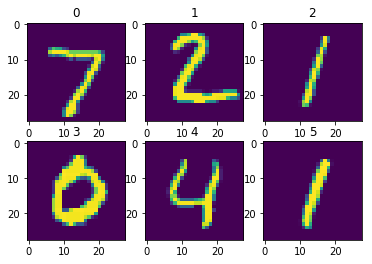

In [9]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_test[i,:,:,0])
    plt.title(str(i))

# Let's pick 10 legit examples to target:

Crafting 10 * 9 adversarial examples


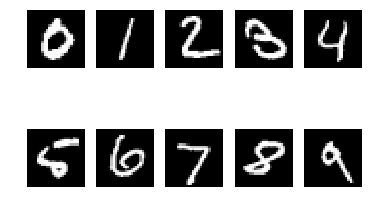

In [10]:
nb_adv_per_sample = str(nb_classes - 1)
print('Crafting ' + str(source_samples) + ' * ' + nb_adv_per_sample + ' adversarial examples')
###########################################################################

assert source_samples == nb_classes
idxs = [np.where(np.argmax(Y_test, axis=1) == i)[0][0] for i in range(nb_classes)]
# [3, 2, 1, 18, 4, 8, 11, 0, 61, 7]
# Pick the first appearances of the 9 numbers in X_test
for i,idx in enumerate(idxs):
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[idx,:,:,0],cmap='gray')
    plt.axis('off')


# Create adv samples using the Carlini-L2 attack:

In [11]:
# Form a 10 x 10 array of the inputs that you seek to target:
adv_inputs = np.array([[instance] * nb_classes for instance in X_test[idxs]],dtype=np.float32)
adv_inputs = adv_inputs.reshape((source_samples * nb_classes, img_rows, img_cols, 1))


one_hot = np.zeros((nb_classes, nb_classes))
one_hot[np.arange(nb_classes), np.arange(nb_classes)] = 1



adv_ys = np.array([one_hot] * source_samples,dtype=np.float32).reshape((source_samples * nb_classes, nb_classes))
# yname = "y_target"
# Instantiate a CW attack object
#model1 = KerasModelWrapper(model)
#(Vishal) model passed into ElasticNetMethod must be of type Model (as defined) so we pass our keras model to the KerasModelWrapper
model_wrap=KerasModelWrapper(model)
cw = ElasticNetMethod(model_wrap, back='tf', sess=sess)
#(Vishal) Changed binary_search_steps and max_iterations to test if the code runs (takes too long for original values)
cw_params = {'binary_search_steps': 1,#15,
             'y_target': adv_ys,
             'max_iterations': 100,#50000,
             'learning_rate': 1.5,
             'batch_size': source_samples * nb_classes if
             targeted else source_samples,
             'initial_const': 1,}

adv = cw.generate_np(adv_inputs, **cw_params)

[INFO 2018-02-18 20:42:51,866 cleverhans] Constructing new graph for attack ElasticNetMethod
[DEBUG 2018-02-18 20:42:53,487 cleverhans] Running EAD attack on instance 0 of 100
[DEBUG 2018-02-18 20:42:53,516 cleverhans]   Binary search step 0 of 1
[DEBUG 2018-02-18 20:42:54,118 cleverhans]     Iteration 0 of 100: loss=9.4e+03 l2=89.8 l1=143 f=-0.0419
[DEBUG 2018-02-18 20:42:59,497 cleverhans]     Iteration 10 of 100: loss=1.01e+04 l2=90.9 l1=140 f=-0.0805
[DEBUG 2018-02-18 20:43:03,345 cleverhans]     Iteration 20 of 100: loss=9.61e+03 l2=86 l1=135 f=-0.0847
[DEBUG 2018-02-18 20:43:09,148 cleverhans]     Iteration 30 of 100: loss=8.99e+03 l2=80 l1=129 f=-0.0649
[DEBUG 2018-02-18 20:43:15,229 cleverhans]     Iteration 40 of 100: loss=8.36e+03 l2=73.9 l1=123 f=-0.0705
[DEBUG 2018-02-18 20:43:21,126 cleverhans]     Iteration 50 of 100: loss=7.49e+03 l2=66 l1=115 f=-0.0637
[DEBUG 2018-02-18 20:43:26,968 cleverhans]     Iteration 60 of 100: loss=6.43e+03 l2=55.7 l1=104 f=-0.06
[DEBUG 2018-02

Text(0,0.5,'Matrix norm dist b/w adv and input image')

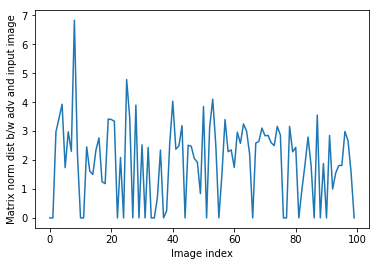

In [12]:
dev=np.zeros(100)
for i in range(100):
    dev[i]=np.linalg.norm(np.abs(adv[i,:,:,0]-adv_inputs[i,:,:,0]))
plt.plot(dev)
plt.xlabel('Image index')
plt.ylabel('Matrix norm dist b/w adv and input image')

In [13]:
np.mod(np.where(dev>0.1)[0],10)

array([2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 5, 6, 8,
       0, 2, 5, 6, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 2, 3, 4, 6, 7, 8,
       9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 8, 9, 0, 2, 3, 4,
       5, 7, 9, 1, 2, 3, 4, 5, 6, 7, 8])

In [14]:
model.predict_classes(adv[np.where(dev>0.1)[0]])

array([2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 3, 5, 6, 8,
       0, 2, 5, 6, 8, 9, 0, 1, 2, 3, 5, 6, 7, 8, 9, 0, 2, 3, 4, 6, 7, 8,
       9, 0, 1, 2, 3, 4, 5, 7, 8, 9, 0, 1, 2, 3, 4, 5, 8, 9, 0, 2, 3, 4,
       5, 7, 9, 1, 2, 3, 4, 5, 6, 7, 8])

In [15]:
np.save('adv_cw_targeted49_model9868.npy',adv)

# Non-targeted:

In [16]:
np.where(dev>0.1)[0]
y_test=np.where(Y_test==1)[1]
adv_inputs=np.zeros((100,28,28,1))
for i in range(10):
    ind_i=np.where(y_test==i)[0][0:10]
    adv_inputs[10*i:10*i+10,:,:,:]=X_test[ind_i]
#model_wrap=KerasModelWrapper(model)
#(Vishal) model_wrap is from the previous model
cw = ElasticNetMethod(model_wrap, back='tf', sess=sess)
#(Vishal) Changed max_iterations to test if the code runs (takes too long for original values)
cw_params = {'binary_search_steps': 10,
             'y_target': None,
             'max_iterations':100,#10000,
             'learning_rate': 2,
             'batch_size':source_samples,
             'initial_const': 50,
            'clip_min' :0,
            'clip_max':1}

adv_nt = cw.generate_np(adv_inputs, **cw_params)

[INFO 2018-02-18 20:43:49,910 cleverhans] Constructing new graph for attack ElasticNetMethod
[DEBUG 2018-02-18 20:43:51,826 cleverhans] Running EAD attack on instance 0 of 100
[DEBUG 2018-02-18 20:43:51,840 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-02-18 20:43:52,070 cleverhans]     Iteration 0 of 100: loss=4.12e+03 l2=412 l1=435 f=0.0277
[DEBUG 2018-02-18 20:43:52,662 cleverhans]     Iteration 10 of 100: loss=4.22e+03 l2=422 l1=445 f=-0.0271
[DEBUG 2018-02-18 20:43:53,307 cleverhans]     Iteration 20 of 100: loss=4.25e+03 l2=424 l1=445 f=-0.00265
[DEBUG 2018-02-18 20:43:53,972 cleverhans]     Iteration 30 of 100: loss=4.29e+03 l2=428 l1=449 f=0.0825
[DEBUG 2018-02-18 20:43:54,616 cleverhans]     Iteration 40 of 100: loss=4.09e+03 l2=409 l1=430 f=-0.0515
[DEBUG 2018-02-18 20:43:55,269 cleverhans]     Iteration 50 of 100: loss=4.34e+03 l2=434 l1=454 f=0.0167
[DEBUG 2018-02-18 20:43:55,894 cleverhans]     Iteration 60 of 100: loss=4.37e+03 l2=436 l1=457 f=0.152
[DEBUG 2018-02-

[DEBUG 2018-02-18 20:44:31,360 cleverhans]     Iteration 10 of 100: loss=3.57e+03 l2=357 l1=416 f=0.0285
[DEBUG 2018-02-18 20:44:32,006 cleverhans]     Iteration 20 of 100: loss=2.58e+03 l2=257 l1=327 f=0.0808
[DEBUG 2018-02-18 20:44:32,644 cleverhans]     Iteration 30 of 100: loss=4.76e+03 l2=475 l1=516 f=-0.0142
[DEBUG 2018-02-18 20:44:33,283 cleverhans]     Iteration 40 of 100: loss=2.65e+03 l2=265 l1=334 f=0.0809
[DEBUG 2018-02-18 20:44:33,912 cleverhans]     Iteration 50 of 100: loss=2.68e+03 l2=267 l1=335 f=0.0583
[DEBUG 2018-02-18 20:44:34,546 cleverhans]     Iteration 60 of 100: loss=5.04e+03 l2=503 l1=539 f=-0.0667
[DEBUG 2018-02-18 20:44:35,193 cleverhans]     Iteration 70 of 100: loss=832 l2=83 l1=155 f=0.0346
[DEBUG 2018-02-18 20:44:35,829 cleverhans]     Iteration 80 of 100: loss=3.9e+03 l2=390 l1=440 f=0.00656
[DEBUG 2018-02-18 20:44:36,480 cleverhans]     Iteration 90 of 100: loss=2.78e+03 l2=278 l1=343 f=0.169
[DEBUG 2018-02-18 20:44:37,041 cleverhans]   Successfully ge

[DEBUG 2018-02-18 20:45:12,615 cleverhans]     Iteration 40 of 100: loss=4.21e+03 l2=406 l1=422 f=-0.45
[DEBUG 2018-02-18 20:45:13,352 cleverhans]     Iteration 50 of 100: loss=4.39e+03 l2=423 l1=439 f=-0.391
[DEBUG 2018-02-18 20:45:14,076 cleverhans]     Iteration 60 of 100: loss=3.26e+03 l2=311 l1=331 f=-0.469
[DEBUG 2018-02-18 20:45:14,723 cleverhans]     Iteration 70 of 100: loss=3.35e+03 l2=318 l1=338 f=-0.341
[DEBUG 2018-02-18 20:45:15,386 cleverhans]     Iteration 80 of 100: loss=4.07e+03 l2=391 l1=406 f=-0.488
[DEBUG 2018-02-18 20:45:16,111 cleverhans]     Iteration 90 of 100: loss=4.3e+03 l2=412 l1=427 f=-0.532
[DEBUG 2018-02-18 20:45:16,720 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:45:16,722 cleverhans]  Elastic Mean successful distortion: 13.68
[DEBUG 2018-02-18 20:45:16,723 cleverhans]   Binary search step 3 of 10
[DEBUG 2018-02-18 20:45:16,784 cleverhans]     Iteration 0 of 100: loss=2.91e+03 l2=291 l1=323 f=-0.14

[DEBUG 2018-02-18 20:46:16,588 cleverhans]     Iteration 80 of 100: loss=844 l2=84.3 l1=144 f=-0.171
[DEBUG 2018-02-18 20:46:17,805 cleverhans]     Iteration 90 of 100: loss=1.92e+03 l2=192 l1=254 f=-0.287
[DEBUG 2018-02-18 20:46:18,998 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:46:19,000 cleverhans]  Elastic Mean successful distortion: 2.915
[DEBUG 2018-02-18 20:46:19,007 cleverhans]   Binary search step 9 of 10
[DEBUG 2018-02-18 20:46:19,145 cleverhans]     Iteration 0 of 100: loss=87.5 l2=8.71 l1=39.3 f=-0.195
[DEBUG 2018-02-18 20:46:20,218 cleverhans]     Iteration 10 of 100: loss=3.54e+03 l2=354 l1=400 f=-0.478
[DEBUG 2018-02-18 20:46:21,439 cleverhans]     Iteration 20 of 100: loss=5.62e+03 l2=562 l1=575 f=-0.578
[DEBUG 2018-02-18 20:46:22,591 cleverhans]     Iteration 30 of 100: loss=5.98e+03 l2=597 l1=606 f=-0.571
[DEBUG 2018-02-18 20:46:23,831 cleverhans]     Iteration 40 of 100: loss=2.36e+03 l2=235 l1=268 f=-0.274
[D

[DEBUG 2018-02-18 20:47:21,183 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:47:21,185 cleverhans]  Elastic Mean successful distortion: 12.41
[DEBUG 2018-02-18 20:47:21,188 cleverhans]   Binary search step 5 of 10
[DEBUG 2018-02-18 20:47:21,311 cleverhans]     Iteration 0 of 100: loss=1.89e+03 l2=189 l1=246 f=-0.376
[DEBUG 2018-02-18 20:47:22,257 cleverhans]     Iteration 10 of 100: loss=3.75e+03 l2=365 l1=401 f=-0.228
[DEBUG 2018-02-18 20:47:23,081 cleverhans]     Iteration 20 of 100: loss=3.28e+03 l2=317 l1=361 f=-0.0805
[DEBUG 2018-02-18 20:47:24,087 cleverhans]     Iteration 30 of 100: loss=1.86e+03 l2=181 l1=237 f=-0.191
[DEBUG 2018-02-18 20:47:25,017 cleverhans]     Iteration 40 of 100: loss=1.73e+03 l2=166 l1=215 f=-0.219
[DEBUG 2018-02-18 20:47:26,150 cleverhans]     Iteration 50 of 100: loss=3.8e+03 l2=355 l1=375 f=-0.421
[DEBUG 2018-02-18 20:47:27,221 cleverhans]     Iteration 60 of 100: loss=1.66e+03 l2=153 l1=200 f=-0.

[DEBUG 2018-02-18 20:47:58,765 cleverhans]     Iteration 0 of 100: loss=3.42e+03 l2=336 l1=358 f=-0.0387
[DEBUG 2018-02-18 20:47:59,897 cleverhans]     Iteration 10 of 100: loss=3.92e+03 l2=258 l1=278 f=-0.382
[DEBUG 2018-02-18 20:48:00,837 cleverhans]     Iteration 20 of 100: loss=4.31e+03 l2=216 l1=234 f=-0.397
[DEBUG 2018-02-18 20:48:01,768 cleverhans]     Iteration 30 of 100: loss=3.6e+03 l2=310 l1=331 f=-0.226
[DEBUG 2018-02-18 20:48:02,782 cleverhans]     Iteration 40 of 100: loss=4.3e+03 l2=270 l1=289 f=-0.0255
[DEBUG 2018-02-18 20:48:03,488 cleverhans]     Iteration 50 of 100: loss=4.18e+03 l2=268 l1=287 f=-0.0333
[DEBUG 2018-02-18 20:48:04,128 cleverhans]     Iteration 60 of 100: loss=3.61e+03 l2=147 l1=166 f=-0.0779
[DEBUG 2018-02-18 20:48:05,019 cleverhans]     Iteration 70 of 100: loss=3.2e+03 l2=282 l1=301 f=-0.234
[DEBUG 2018-02-18 20:48:05,795 cleverhans]     Iteration 80 of 100: loss=3.97e+03 l2=350 l1=369 f=-0.163
[DEBUG 2018-02-18 20:48:06,338 cleverhans]     Iteratio

[DEBUG 2018-02-18 20:48:43,819 cleverhans]     Iteration 30 of 100: loss=5.32e+03 l2=530 l1=549 f=-0.0811
[DEBUG 2018-02-18 20:48:44,576 cleverhans]     Iteration 40 of 100: loss=2.19e+03 l2=219 l1=273 f=0.195
[DEBUG 2018-02-18 20:48:45,329 cleverhans]     Iteration 50 of 100: loss=501 l2=49.9 l1=103 f=-0.117
[DEBUG 2018-02-18 20:48:45,905 cleverhans]     Iteration 60 of 100: loss=2.52e+03 l2=251 l1=298 f=0.142
[DEBUG 2018-02-18 20:48:46,627 cleverhans]     Iteration 70 of 100: loss=500 l2=49.8 l1=101 f=0.0894
[DEBUG 2018-02-18 20:48:47,261 cleverhans]     Iteration 80 of 100: loss=2.44e+03 l2=244 l1=296 f=0.0232
[DEBUG 2018-02-18 20:48:47,914 cleverhans]     Iteration 90 of 100: loss=599 l2=59.7 l1=112 f=-0.108
[DEBUG 2018-02-18 20:48:48,532 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:48:48,533 cleverhans]  Elastic Mean successful distortion: 6.058
[DEBUG 2018-02-18 20:48:48,536 cleverhans]   Binary search step 8 of 10
[DEBUG 2

[DEBUG 2018-02-18 20:49:32,827 cleverhans]     Iteration 60 of 100: loss=3.2e+03 l2=320 l1=353 f=0.0522
[DEBUG 2018-02-18 20:49:33,624 cleverhans]     Iteration 70 of 100: loss=4.82e+03 l2=482 l1=506 f=-0.312
[DEBUG 2018-02-18 20:49:34,284 cleverhans]     Iteration 80 of 100: loss=3.29e+03 l2=328 l1=363 f=0.119
[DEBUG 2018-02-18 20:49:35,023 cleverhans]     Iteration 90 of 100: loss=3.3e+03 l2=329 l1=363 f=0.109
[DEBUG 2018-02-18 20:49:35,645 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:49:35,649 cleverhans]  Elastic Mean successful distortion: 16.75
[DEBUG 2018-02-18 20:49:35,651 cleverhans]   Binary search step 4 of 10
[DEBUG 2018-02-18 20:49:35,728 cleverhans]     Iteration 0 of 100: loss=2.55e+03 l2=255 l1=306 f=0.134
[DEBUG 2018-02-18 20:49:36,229 cleverhans]     Iteration 10 of 100: loss=4.71e+03 l2=471 l1=501 f=-0.43
[DEBUG 2018-02-18 20:49:36,793 cleverhans]     Iteration 20 of 100: loss=4.62e+03 l2=462 l1=496 f=-0.3
[DEB

[DEBUG 2018-02-18 20:50:11,965 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:50:11,966 cleverhans]  Elastic Mean successful distortion: 3.649
[DEBUG 2018-02-18 20:50:11,967 cleverhans] Running EAD attack on instance 50 of 100
[DEBUG 2018-02-18 20:50:11,972 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-02-18 20:50:12,049 cleverhans]     Iteration 0 of 100: loss=4.2e+03 l2=367 l1=387 f=-0.14
[DEBUG 2018-02-18 20:50:12,581 cleverhans]     Iteration 10 of 100: loss=4.49e+03 l2=250 l1=269 f=-0.326
[DEBUG 2018-02-18 20:50:13,176 cleverhans]     Iteration 20 of 100: loss=5.62e+03 l2=212 l1=231 f=-0.22
[DEBUG 2018-02-18 20:50:13,652 cleverhans]     Iteration 30 of 100: loss=4.01e+03 l2=296 l1=315 f=-0.289
[DEBUG 2018-02-18 20:50:14,136 cleverhans]     Iteration 40 of 100: loss=4.65e+03 l2=291 l1=310 f=0.105
[DEBUG 2018-02-18 20:50:14,612 cleverhans]     Iteration 50 of 100: loss=4.02e+03 l2=317 l1=335 f=0.194
[DEBUG 2018-02-18 20:5

[DEBUG 2018-02-18 20:50:48,958 cleverhans]     Iteration 0 of 100: loss=1.4e+03 l2=136 l1=191 f=-0.0853
[DEBUG 2018-02-18 20:50:49,441 cleverhans]     Iteration 10 of 100: loss=2.51e+03 l2=233 l1=275 f=-0.13
[DEBUG 2018-02-18 20:50:49,945 cleverhans]     Iteration 20 of 100: loss=3.91e+03 l2=358 l1=380 f=-0.521
[DEBUG 2018-02-18 20:50:50,423 cleverhans]     Iteration 30 of 100: loss=2.39e+03 l2=212 l1=247 f=-0.246
[DEBUG 2018-02-18 20:50:50,891 cleverhans]     Iteration 40 of 100: loss=3.49e+03 l2=317 l1=343 f=-0.452
[DEBUG 2018-02-18 20:50:51,412 cleverhans]     Iteration 50 of 100: loss=3.9e+03 l2=351 l1=377 f=-0.589
[DEBUG 2018-02-18 20:50:52,011 cleverhans]     Iteration 60 of 100: loss=1.49e+03 l2=134 l1=180 f=-0.192
[DEBUG 2018-02-18 20:50:52,686 cleverhans]     Iteration 70 of 100: loss=1.5e+03 l2=126 l1=172 f=-0.286
[DEBUG 2018-02-18 20:50:53,331 cleverhans]     Iteration 80 of 100: loss=1.91e+03 l2=162 l1=202 f=-0.595
[DEBUG 2018-02-18 20:50:53,866 cleverhans]     Iteration 90

[DEBUG 2018-02-18 20:51:19,760 cleverhans]     Iteration 30 of 100: loss=3.58e+03 l2=357 l1=386 f=-0.859
[DEBUG 2018-02-18 20:51:20,266 cleverhans]     Iteration 40 of 100: loss=4.31e+03 l2=431 l1=456 f=-0.766
[DEBUG 2018-02-18 20:51:20,717 cleverhans]     Iteration 50 of 100: loss=3.48e+03 l2=334 l1=362 f=-0.625
[DEBUG 2018-02-18 20:51:21,215 cleverhans]     Iteration 60 of 100: loss=4.17e+03 l2=402 l1=426 f=-0.766
[DEBUG 2018-02-18 20:51:21,752 cleverhans]     Iteration 70 of 100: loss=3.29e+03 l2=316 l1=344 f=-0.746
[DEBUG 2018-02-18 20:51:22,226 cleverhans]     Iteration 80 of 100: loss=4.27e+03 l2=409 l1=433 f=-0.939
[DEBUG 2018-02-18 20:51:22,657 cleverhans]     Iteration 90 of 100: loss=3.37e+03 l2=323 l1=352 f=-0.654
[DEBUG 2018-02-18 20:51:23,035 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:51:23,036 cleverhans]  Elastic Mean successful distortion: 13.88
[DEBUG 2018-02-18 20:51:23,037 cleverhans]   Binary search step 3 o

[DEBUG 2018-02-18 20:51:52,064 cleverhans]     Iteration 70 of 100: loss=1.12e+03 l2=112 l1=184 f=-0.417
[DEBUG 2018-02-18 20:51:52,630 cleverhans]     Iteration 80 of 100: loss=1.08e+03 l2=108 l1=179 f=-0.491
[DEBUG 2018-02-18 20:51:53,289 cleverhans]     Iteration 90 of 100: loss=2.39e+03 l2=238 l1=303 f=-0.669
[DEBUG 2018-02-18 20:51:53,755 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:51:53,758 cleverhans]  Elastic Mean successful distortion: 2.865
[DEBUG 2018-02-18 20:51:53,762 cleverhans]   Binary search step 9 of 10
[DEBUG 2018-02-18 20:51:53,836 cleverhans]     Iteration 0 of 100: loss=83.5 l2=8.31 l1=42.5 f=0.187
[DEBUG 2018-02-18 20:51:54,393 cleverhans]     Iteration 10 of 100: loss=947 l2=94.5 l1=165 f=-0.421
[DEBUG 2018-02-18 20:51:54,867 cleverhans]     Iteration 20 of 100: loss=4.16e+03 l2=415 l1=459 f=-0.625
[DEBUG 2018-02-18 20:51:55,375 cleverhans]     Iteration 30 of 100: loss=281 l2=28 l1=76.5 f=0.0449
[DEBUG 2

[DEBUG 2018-02-18 20:52:20,504 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:52:20,505 cleverhans]  Elastic Mean successful distortion: 12.71
[DEBUG 2018-02-18 20:52:20,506 cleverhans]   Binary search step 5 of 10
[DEBUG 2018-02-18 20:52:20,577 cleverhans]     Iteration 0 of 100: loss=1.56e+03 l2=155 l1=212 f=0.0284
[DEBUG 2018-02-18 20:52:21,155 cleverhans]     Iteration 10 of 100: loss=1.79e+03 l2=177 l1=229 f=0.188
[DEBUG 2018-02-18 20:52:21,810 cleverhans]     Iteration 20 of 100: loss=1.63e+03 l2=162 l1=213 f=0.16
[DEBUG 2018-02-18 20:52:22,305 cleverhans]     Iteration 30 of 100: loss=1.48e+03 l2=144 l1=191 f=0.128
[DEBUG 2018-02-18 20:52:22,895 cleverhans]     Iteration 40 of 100: loss=1.5e+03 l2=145 l1=192 f=0.0905
[DEBUG 2018-02-18 20:52:23,364 cleverhans]     Iteration 50 of 100: loss=2.92e+03 l2=279 l1=307 f=0.148
[DEBUG 2018-02-18 20:52:23,805 cleverhans]     Iteration 60 of 100: loss=3.39e+03 l2=329 l1=357 f=0.0422
[D

[DEBUG 2018-02-18 20:52:49,842 cleverhans]     Iteration 10 of 100: loss=3.83e+03 l2=373 l1=394 f=0.0592
[DEBUG 2018-02-18 20:52:50,355 cleverhans]     Iteration 20 of 100: loss=4.16e+03 l2=249 l1=271 f=-0.299
[DEBUG 2018-02-18 20:52:50,777 cleverhans]     Iteration 30 of 100: loss=3.37e+03 l2=266 l1=288 f=-0.201
[DEBUG 2018-02-18 20:52:51,174 cleverhans]     Iteration 40 of 100: loss=3.7e+03 l2=291 l1=312 f=-0.219
[DEBUG 2018-02-18 20:52:51,604 cleverhans]     Iteration 50 of 100: loss=3.85e+03 l2=212 l1=233 f=-0.352
[DEBUG 2018-02-18 20:52:52,068 cleverhans]     Iteration 60 of 100: loss=3.61e+03 l2=267 l1=288 f=-0.202
[DEBUG 2018-02-18 20:52:52,456 cleverhans]     Iteration 70 of 100: loss=3.51e+03 l2=309 l1=331 f=-0.127
[DEBUG 2018-02-18 20:52:52,893 cleverhans]     Iteration 80 of 100: loss=3.78e+03 l2=329 l1=351 f=-0.267
[DEBUG 2018-02-18 20:52:53,300 cleverhans]     Iteration 90 of 100: loss=3.5e+03 l2=306 l1=329 f=-0.342
[DEBUG 2018-02-18 20:52:53,681 cleverhans]   Successfully

[DEBUG 2018-02-18 20:53:20,130 cleverhans]     Iteration 40 of 100: loss=1.79e+03 l2=179 l1=246 f=0.111
[DEBUG 2018-02-18 20:53:20,661 cleverhans]     Iteration 50 of 100: loss=470 l2=46.9 l1=106 f=-0.0489
[DEBUG 2018-02-18 20:53:21,169 cleverhans]     Iteration 60 of 100: loss=476 l2=47.5 l1=108 f=-0.0693
[DEBUG 2018-02-18 20:53:21,648 cleverhans]     Iteration 70 of 100: loss=4.54e+03 l2=454 l1=485 f=0.00775
[DEBUG 2018-02-18 20:53:22,060 cleverhans]     Iteration 80 of 100: loss=5.37e+03 l2=536 l1=556 f=-0.0618
[DEBUG 2018-02-18 20:53:22,510 cleverhans]     Iteration 90 of 100: loss=1.8e+03 l2=180 l1=248 f=0.109
[DEBUG 2018-02-18 20:53:22,927 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:53:22,928 cleverhans]  Elastic Mean successful distortion: 5.869
[DEBUG 2018-02-18 20:53:22,929 cleverhans]   Binary search step 8 of 10
[DEBUG 2018-02-18 20:53:23,006 cleverhans]     Iteration 0 of 100: loss=113 l2=11.3 l1=48 f=-0.31
[DEBUG 20

[DEBUG 2018-02-18 20:53:47,993 cleverhans]     Iteration 70 of 100: loss=2.37e+03 l2=236 l1=267 f=0.35
[DEBUG 2018-02-18 20:53:48,577 cleverhans]     Iteration 80 of 100: loss=2.55e+03 l2=254 l1=285 f=0.29
[DEBUG 2018-02-18 20:53:49,177 cleverhans]     Iteration 90 of 100: loss=2.53e+03 l2=253 l1=284 f=0.105
[DEBUG 2018-02-18 20:53:49,636 cleverhans]   Successfully generated adversarial examples on 10 of 10 instances.
[DEBUG 2018-02-18 20:53:49,637 cleverhans]  Elastic Mean successful distortion: 10.14
[DEBUG 2018-02-18 20:53:49,639 cleverhans]   Binary search step 4 of 10
[DEBUG 2018-02-18 20:53:49,707 cleverhans]     Iteration 0 of 100: loss=2.28e+03 l2=228 l1=271 f=0.213
[DEBUG 2018-02-18 20:53:50,153 cleverhans]     Iteration 10 of 100: loss=2.23e+03 l2=223 l1=267 f=0.152
[DEBUG 2018-02-18 20:53:50,608 cleverhans]     Iteration 20 of 100: loss=4.11e+03 l2=410 l1=443 f=0.00756
[DEBUG 2018-02-18 20:53:50,992 cleverhans]     Iteration 30 of 100: loss=2.12e+03 l2=212 l1=255 f=0.321
[DE

[DEBUG 2018-02-18 20:54:17,396 cleverhans]  Elastic Mean successful distortion: 2.804


Text(0,0.5,'Matrix norm dist b/w adv and input image')

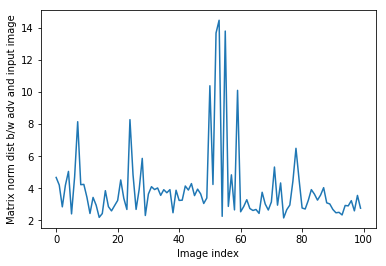

In [17]:
dev_nt=np.zeros(100)
for i in range(100):
    dev_nt[i]=np.linalg.norm(np.abs(adv_nt[i,:,:,0]-adv_inputs[i,:,:,0]))
plt.plot(dev_nt)
plt.xlabel('Image index')
plt.ylabel('Matrix norm dist b/w adv and input image')

In [18]:
len(np.where(dev_nt<0.01)[0])

0

In [19]:
model.predict_classes(adv_inputs)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [20]:
model.predict_classes(adv_nt)

array([7, 9, 9, 9, 2, 8, 6, 9, 6, 9, 8, 7, 8, 3, 4, 7, 8, 7, 2, 7, 1, 1,
       3, 1, 3, 3, 1, 7, 7, 7, 8, 9, 5, 5, 8, 8, 8, 5, 7, 5, 9, 9, 7, 9,
       9, 2, 9, 9, 9, 9, 2, 3, 3, 8, 9, 3, 9, 9, 9, 9, 0, 5, 4, 5, 5, 0,
       9, 8, 5, 5, 9, 3, 9, 2, 2, 2, 5, 3, 2, 4, 2, 5, 3, 3, 3, 9, 9, 3,
       5, 3, 5, 4, 4, 4, 4, 4, 5, 8, 4, 4])

In [21]:
(model.predict_classes(adv_nt)==model.predict_classes(adv_inputs)).sum()

0

In [22]:
np.save('adv_cw_nontargeted88_model9868.npy',adv_nt)

# F-MNIST transfer learning here:

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        4160      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         295040    
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         409728    
_________________________________________________________________
activation_3 (Activation)    (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

#  Fashion-MNIST dataset:

## Label	Description :
 - 0:	T-shirt/top
 - 1	Trouser
 - 2	Pullover
 - 3	Dress
 - 4	Coat
 - 5	trouser
 - 6	Shirt
 - 7	tshirt
 - 8	Bag
 - 9	Ankle boot
 
 
 Source: github.com/zalandoresearch/fashion-mnist

2


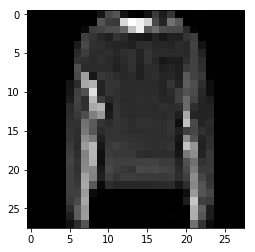

In [24]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(),'fashion_mnist'))
from utils import mnist_reader
#(Vishal) changed test to train
X_train_vec, y_train_vec = mnist_reader.load_mnist('data/fashion', kind='train')
X_test_vec, y_test_vec = mnist_reader.load_mnist('data/fashion', kind='t10k')
#(Vishal) changed test to train
X_train_vec = X_train_vec.astype('float32')
X_test_vec = X_test_vec.astype('float32')
#(Vishal) changed test to train
X_train_vec /= 255
X_test_vec /= 255
from keras.utils import np_utils
#(Vishal) changed test to train
X_train_f=X_train_vec.reshape(60000,28,28,1)
X_test_f=X_test_vec.reshape(10000,28,28,1)
#(Vishal) changed test to train
Y_train_f=np_utils.to_categorical(y_train_vec, num_classes=10)
Y_test_f=np_utils.to_categorical(y_test_vec, num_classes=10)
#Let's display a tshirt:

%matplotlib inline
plt.imshow(X_test_f[243,:,:,0],cmap='gray')
print(np.argmax(Y_test_f[243]))
nb_classes=10

In [25]:
from sklearn.manifold import TSNE

Text(0.5,1,'2D t-SNE plot of the 128-D deep features (Test)')

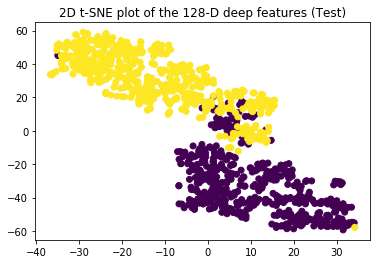

In [26]:
ind_tshirt=np.where(y_test_vec==0)[0][0:600]
ind_trouser=np.where(y_test_vec==1)[0][0:600]
X_tshirt=X_test_f[ind_tshirt]
X_trouser=X_test_f[ind_trouser]
#(Vishal) changed test to train
X_tshirt_train=X_tshirt[0:500]
#(Vishal) changed test to train
X_trouser_train=X_trouser[0:500]
X_tshirt_test=X_tshirt[500:]
X_trouser_test=X_trouser[500:]
#(Vishal) changed test to train
X_tt_train=np.vstack([X_trouser_train,X_tshirt_train])
X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])
#(Vishal) changed layer index to match the new model designed (cnn_keras)
get_3rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[6].output])
#(Vishal) changed test to train
X_tt_train_feat=get_3rd_layer_output([X_tt_train, 0])[0]
#(Vishal) changed test to train
X_tt_embedded_train = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_train_feat)
#(Vishal) changed test to train
y_tt_train=np.zeros(1000)#1000
#(Vishal) changed test to train
y_tt_train[500:]=1#200
#(Vishal) changed test to train
plt.scatter(X_tt_embedded_train[:,0],X_tt_embedded_train[:,1],c=y_tt_train)
plt.title('2D t-SNE plot of the 128-D deep features (Test)')

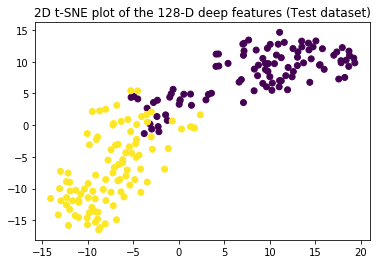

In [27]:
#(Vishal) repeating code, to obtain same information
#ind_tshirt=np.where(y_test_vec==0)[0][0:600]
#ind_trouser=np.where(y_test_vec==1)[0][0:600]
#X_tshirt=X_test_f[ind_tshirt]
#X_trouser=X_test_f[ind_trouser]
#X_tshirt_test=X_tshirt[0:500]
#X_trouser_test=X_trouser[0:500]
#X_tshirt_test=X_tshirt[500:]
#X_trouser_test=X_trouser[500:]
#X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])
#X_tt_test=np.vstack([X_trouser_test,X_tshirt_test])

get_3rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[6].output])
#(Vishal) This time we keep it as test
X_tt_test_feat=get_3rd_layer_output([X_tt_test, 0])[0]
X_tt_embedded_test = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat)
y_tt_test=np.zeros(200)
y_tt_test[100:]=1
plt.scatter(X_tt_embedded_test[:,0],X_tt_embedded_test[:,1],c=y_tt_test)
plt.title('2D t-SNE plot of the 128-D deep features (Test dataset)')
plt.show()

In [28]:
X_tt_test_feat[:,0]

array([0.5503826 , 0.        , 0.13611422, 0.42266604, 0.        ,
       1.0148538 , 0.5526203 , 1.0164927 , 1.3722296 , 0.13073052,
       0.6968076 , 0.88188493, 0.11200359, 0.6738504 , 1.001497  ,
       0.22576524, 0.7339825 , 0.4179108 , 0.35899723, 0.44777897,
       0.06866062, 0.26955017, 0.3413568 , 0.        , 0.6425289 ,
       0.4386805 , 0.        , 0.46918678, 0.00923382, 0.3209905 ,
       0.6301681 , 0.7641543 , 0.        , 0.38282633, 0.5324605 ,
       0.8274627 , 0.27822343, 0.        , 0.8997735 , 1.0458293 ,
       0.        , 0.        , 0.29673737, 0.5990784 , 0.3504678 ,
       1.064376  , 0.6318039 , 0.        , 0.32631373, 0.6818948 ,
       1.7584597 , 1.4237841 , 0.        , 0.        , 0.        ,
       0.        , 0.31165895, 0.22844811, 0.34390315, 0.9910431 ,
       1.0210991 , 0.27690947, 0.49062014, 1.2808709 , 0.6305193 ,
       0.6035753 , 0.74643505, 0.        , 0.6980756 , 0.        ,
       0.24085857, 0.4860042 , 0.15338975, 0.        , 0.57384

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='linear')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat, y_tt_train)  
y_pred_svc=clf.predict(X_tt_test_feat)
confusion_matrix(y_tt_test, y_pred_svc)

array([[99,  1],
       [ 3, 97]])

Text(0,0.5,'Counts')

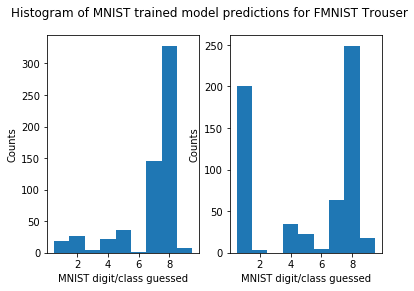

In [30]:
plt.figure(2)
plt.subplot(121)
plt.hist(model.predict_classes(X_tshirt),bins=np.arange(0.5,10.5))
plt.xlabel('MNIST digit/class guessed')
plt.ylabel('Counts')
plt.subplot(122)
plt.hist(model.predict_classes(X_trouser),bins=np.arange(0.5,10.5))
plt.xlabel('MNIST digit/class guessed')
plt.suptitle('Histogram of MNIST trained model predictions for FMNIST Trouser')
plt.ylabel('Counts')

In [31]:
model.predict_classes(X_test[0:6,:,:,:])
#sess.run(preds, feed_dict={x: X_test[0:6,:,:,:]}).argmax(-1)

array([7, 2, 1, 0, 4, 1])

In [32]:
X_tt_test.shape

(200, 28, 28, 1)

(-0.5, 27.5, 27.5, -0.5)

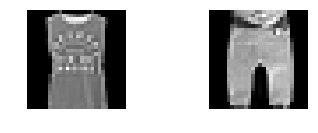

In [33]:
plt.subplot(2,2,1)
plt.imshow(X_tt_test[141,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(X_tt_test[41,:,:,0],cmap='gray')
plt.axis('off')

# Generate un-targeted adversarial examples for the 2-class FMNIST problem:

In [34]:

cw = ElasticNetMethod(model_wrap, back='tf', sess=sess)
#(Vishal) Changed max_iterations to test if the code runs (takes too long for original values)
cw_params = {'binary_search_steps': 1,
             'y_target': None,
             'max_iterations':20,#10000,
             'learning_rate': 0.9,
             'batch_size':1000,
             'initial_const':0.5,
            'clip_min' :0,
            'clip_max':1}

X_tt_train_adv = cw.generate_np(X_tt_train, **cw_params)
#(Vishal) Changed max_iterations to test if the code runs (takes too long for original values)
cw = ElasticNetMethod(model_wrap, back='tf', sess=sess)
cw_params = {'binary_search_steps': 1,
             'y_target': None,
             'max_iterations':20,#10000,
             'learning_rate': 0.9,
             'batch_size':200,
             'initial_const':0.5,
            'clip_min' :0,
            'clip_max':1}
X_tt_test_adv = cw.generate_np(X_tt_test, **cw_params)

[INFO 2018-02-18 20:54:51,604 cleverhans] Constructing new graph for attack ElasticNetMethod
[DEBUG 2018-02-18 20:54:53,916 cleverhans] Running EAD attack on instance 0 of 1000
[DEBUG 2018-02-18 20:54:54,080 cleverhans]   Binary search step 0 of 1
[DEBUG 2018-02-18 20:54:58,736 cleverhans]     Iteration 0 of 20: loss=4.8e+03 l2=4.76 l1=34.6 f=-0.0832
[DEBUG 2018-02-18 20:55:08,891 cleverhans]     Iteration 2 of 20: loss=5.62e+03 l2=5.58 l1=37.5 f=-0.105
[DEBUG 2018-02-18 20:55:16,646 cleverhans]     Iteration 4 of 20: loss=5.7e+03 l2=5.66 l1=37.6 f=-0.0741
[DEBUG 2018-02-18 20:55:23,662 cleverhans]     Iteration 6 of 20: loss=5.57e+03 l2=5.51 l1=37.3 f=-0.0775
[DEBUG 2018-02-18 20:55:30,778 cleverhans]     Iteration 8 of 20: loss=4.29e+03 l2=4.24 l1=32.1 f=-0.0857
[DEBUG 2018-02-18 20:55:37,563 cleverhans]     Iteration 10 of 20: loss=3.94e+03 l2=3.88 l1=30.6 f=-0.104
[DEBUG 2018-02-18 20:55:44,968 cleverhans]     Iteration 12 of 20: loss=2.14e+03 l2=2.11 l1=22.6 f=-0.111
[DEBUG 2018-0

(-0.5, 27.5, 27.5, -0.5)

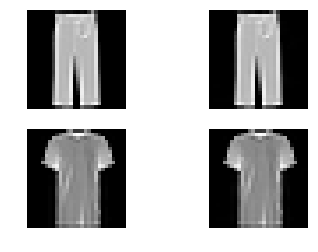

In [35]:
plt.subplot(2,2,1)
#(Vishal) changed test to train
plt.imshow(X_tt_train[243,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
#(Vishal) changed test to train
plt.imshow(X_tt_train_adv[243,:,:,0],cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
#(Vishal) changed test to train
plt.imshow(X_tt_train[543,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
#(Vishal) changed test to train
plt.imshow(X_tt_train_adv[543,:,:,0],cmap='gray')
plt.axis('off')

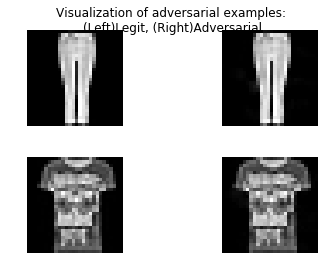

In [36]:
plt.subplot(2,2,1)
plt.imshow(X_tt_test[43,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(X_tt_test_adv[43,:,:,0],cmap='gray')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(X_tt_test[143,:,:,0],cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(X_tt_test_adv[143,:,:,0],cmap='gray')
plt.axis('off')
plt.suptitle('Visualization of adversarial examples: \n(Left)Legit, (Right)Adversarial')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Confirming that the damage is indeed done

In [37]:
(model.predict_classes(X_tt_train)==model.predict_classes(X_tt_train_adv)).sum()

0

In [38]:
(model.predict_classes(X_tt_test)==model.predict_classes(X_tt_test_adv)).sum()

0

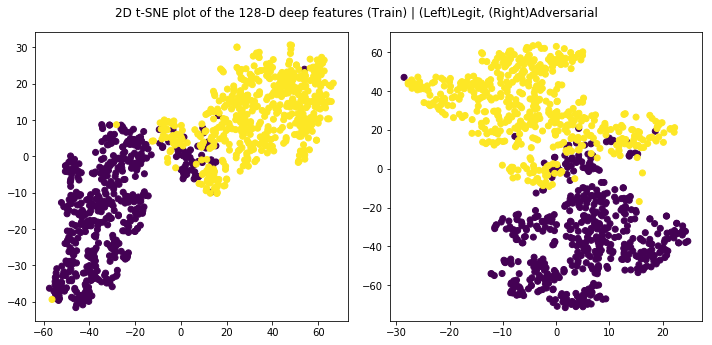

In [39]:
#(Vishal) repeated for train (previously only test was present)
#(Vishal) changed test to train (was commented out originally)
X_tt_train_feat=get_3rd_layer_output([X_tt_train, 0])[0]
X_tt_embedded_train = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_train_feat)
y_tt_train=np.zeros(1000)
y_tt_train[500:]=1
plt.figure(figsize=(10,5))
plt.subplot(121)
#(Vishal) changed test to train
plt.scatter(X_tt_embedded_train[:,0],X_tt_embedded_train[:,1],c=y_tt_train)


#(Vishal) changed test to train (was commented out originally)
X_tt_train_feat_adv=get_3rd_layer_output([X_tt_train_adv, 0])[0]
X_tt_embedded_train_adv = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_train_feat_adv)
y_tt_train=np.zeros(1000)
y_tt_train[500:]=1
plt.subplot(122)
#(Vishal) changed test to train
plt.scatter(X_tt_embedded_train_adv[:,0],X_tt_embedded_train_adv[:,1],c=y_tt_train)

plt.suptitle('2D t-SNE plot of the 128-D deep features (Train) | (Left)Legit, (Right)Adversarial')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

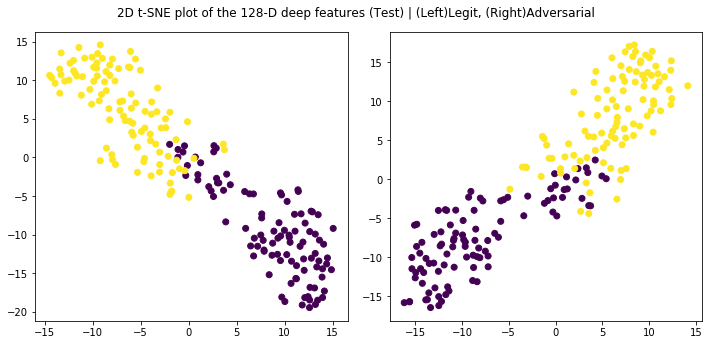

In [40]:
X_tt_test_feat=get_3rd_layer_output([X_tt_test, 0])[0]
X_tt_embedded_test = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat)
y_tt_test=np.zeros(200)
y_tt_test[100:]=1
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(X_tt_embedded_test[:,0],X_tt_embedded_test[:,1],c=y_tt_test)



X_tt_test_feat_adv=get_3rd_layer_output([X_tt_test_adv, 0])[0]
X_tt_embedded_test_adv = TSNE(n_components=2,perplexity=25).fit_transform(X_tt_test_feat_adv)
y_tt_test=np.zeros(200)
y_tt_test[100:]=1
plt.subplot(122)
plt.scatter(X_tt_embedded_test_adv[:,0],X_tt_embedded_test_adv[:,1],c=y_tt_test)

plt.suptitle('2D t-SNE plot of the 128-D deep features (Test) | (Left)Legit, (Right)Adversarial')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [41]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='rbf')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat)
print(confusion_matrix(y_tt_test, y_pred_svc))

clf = SVC( kernel='linear')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat)
confusion_matrix(y_tt_test, y_pred_svc)

[[ 91   9]
 [  0 100]]


array([[99,  1],
       [ 3, 97]])

In [42]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
clf = SVC( kernel='rbf')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat_adv, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat_adv)
print(confusion_matrix(y_tt_test, y_pred_svc))

clf = SVC( kernel='linear')
#(Vishal) changed test to train
clf.fit(X_tt_train_feat_adv, y_tt_train) 
y_pred_svc=clf.predict(X_tt_test_feat_adv)
confusion_matrix(y_tt_test, y_pred_svc)

[[ 94   6]
 [  0 100]]


array([[96,  4],
       [ 3, 97]])

In [43]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import pydot
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

I modified the code, to run from start to finish. I have added comments to indicate where I have made changes. They begin with (Vishal) to easily identify them. 

This code runs the ElasticNetMethod instead of the CarliniWagnerL2 method.

Since I did not have access to run on GPUs, i reduced the number of iterations to test it (also commented in the code)